# Python Control Module   
MATLAB is the leading software vendor for computing and visualizing control systems with Simulink. 
A control system regulates the output or feedback of another component or system. 

Linear control systems use linear negative feedback to produce a control signal mathematically based on other variables, with a view to maintain the controlled process within an acceptable operating range.

The objective of control engineering is to model the system, find its frequency response, and find the variables which provide the optimal response, if it is possible. 

The University of Michigan has an excellent resource for an introduction on [System Modeling](http://ctms.engin.umich.edu/CTMS/index.php?example=Introduction&section=SystemModeling), [Analysis](http://ctms.engin.umich.edu/CTMS/index.php?example=Introduction&section=SystemAnalysis), which we will model with Python instead of MATLAB in this notebook service.

The Python community, seeing the need to replicate the great functions MATLAB offers to conduct control enginnering simulations, created the [python-control package](http://sourceforge.net/projects/python-control/). This notebook service will create a linear control system model, analyze it and find the root locus. 
For this, we will need to install the following packages:


## Ball and Beam

A ball is placed on a beam, see figure below, where it is allowed to roll with 1 degree of freedom along the length of the beam. A lever arm is attached to the beam at one end and a servo gear at the other. As the servo gear turns by an angle $\theta$, the lever changes the angle of the beam by $\alpha$. When the angle is changed from the horizontal position, gravity causes the ball to roll along the beam. A controller will be designed for this system so that the ball's position can be manipulated.
For this problem, we will assume that the ball rolls without slipping and friction between the beam and ball is negligible. 

<img src="http://ctms.engin.umich.edu/CTMS/Content/BallBeam/System/Modeling/figures/bb2.png">

`simpy` allows you to define transfer functions using a symbolic variable, `s` in this case. 

In [1]:
import sympy
from sympy import *
sympy.init_printing()
s = Symbol('s')   

The system parameters are as follows:

In [2]:
#system parameters
m = 0.04;          # mass of the ball  (kg)
R = 0.0127;        # radius of the ball   (meters)   
g = -9.81;         # gravitational acceleration (meters/s^2)
L = 0.4;           # length of the beam    (meters)
d = 0.05;          # lever arm offset (meters)
J = 0.00000258064; # ball's moment of inertia (kg.m^2)  
#(r)      ball position coordinate
#(alpha)  beam angle coordinate
#(theta)  servo gear angle

The significance of this system is that it is a simple system which is unstable on its own (the ball rolls to the edge of the beam without resistance as can be seen above). What is needed is to measure $r$ to control $\theta$ which affects $\alpha$ and moves $r$.

As described by the University of Michigan's resource of the [system model](http://ctms.engin.umich.edu/CTMS/index.php?example=BallBeam&section=SystemModeling), [Langrangian equations](http://en.wikipedia.org/wiki/Lagrangian_mechanics) and [linearization](http://en.wikipedia.org/wiki/Linearization) simplify the problem to:   

$$\ddot{r}(\frac{J}{R^2}+m)= -\frac{mgd}{L}\theta$$


Applying the laplace transform to the equation above

$$(\frac{J}{R}^2+m)R(s)s^2 = -mg\frac{d}{L}\theta(s)$$

Leads to the transfer function $T(s)$:


$$T(s)= \frac{R(s)}{\theta(s)}= -\frac{mgd}{L(\frac{J}{R^2}+m)}\frac{1}{s^2}$$

It should be noted that this transfer function is a [double integrator](http://en.wikipedia.org/wiki/Double_integrator). As such it is marginally stable and will provide a challenging control problem.

The transfer function can be implemented in python with `simpy` and `python-control` as follows:

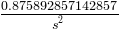

In [3]:
Ts = -m*g*d/L/(J/R**2+m)/s**2
Ts.simplify()

In [4]:
import control
from numpy import *             # Grab all of the NumPy functions
from control import matlab
from control.matlab import *    # MATLAB-like functions
from matplotlib.pyplot import * # Grab MATLAB plotting functions
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
#transform to a py-control transfer function
num = Poly(Ts.as_numer_denom()[0],s).all_coeffs()
den = Poly(Ts.as_numer_denom()[1],s).all_coeffs()
P_ball =  tf(map(float,num),map(float,den))
P_ball


0.8759
------
  s^2

Now we will apply the [step response](http://en.wikipedia.org/wiki/Step_response) to see how the system behaves in an open loop, that is, if we gave the ball a push and there was no control system on it. 

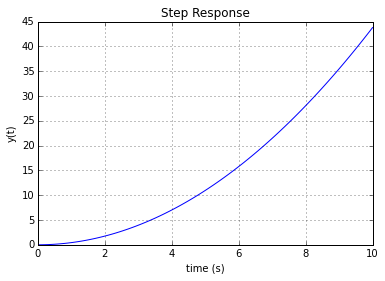

In [6]:
t, y = matlab.step(P_ball,T=linspace(0,10,100))
plot(y, t)
title("Step Response")
grid()
xlabel("time (s)")
ylabel("y(t)")

The system is unstable, we will control it to receive a desired response (a value) that doesn't overshoot nor is too slow in a feedback system we will implement. This figure provides some common response to a step function:  
<img src= http://www1.adept.com/main/KE/DATA/Controller/SmartMotion_Developer/images/AM%20typ%20response%20to%20step_575x510.gif>

There are many ways to control including PID, Root Locus, Bode and State Space.

###Root Locus
The main idea of the [root locus design](http://en.wikipedia.org/wiki/Root_locus) is to estimate the closed-loop response from the open-loop root locus plot. By adding [zeroes](http://en.wikipedia.org/wiki/Zero_of_a_function) and/or [poles](http://en.wikipedia.org/wiki/Pole_(complex_analysis)) to the original system (adding a compensator), the root locus and thus the closed-loop response will be modified. Let's view the root locus for the plant in open loop. 

/home/notebook/ka_env/lib/python2.7/site-packages/numpy/core/numeric.py:462: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


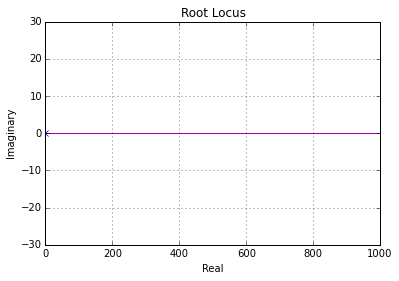

In [7]:
r, k = rlocus(P_ball)
title("Root Locus")
plot(k,r)
grid()
show()

The system has two poles at the origin which go off to infinity in the imaginary axis. 

In [8]:
pole(P_ball)

array([ 0.,  0.])

In [9]:
zero(P_ball)

array([], dtype=float64)

###Lead Controller 
A first order [lead compensator](http://en.wikipedia.org/wiki/Lead%E2%80%93lag_compensator) tends to shift the root locus into the left-hand plane.
 A lead compensator has the form given below:
 
 $C(s)=K_c\frac{s-z_0}{s-p_0}$ where $z_0<p_0$

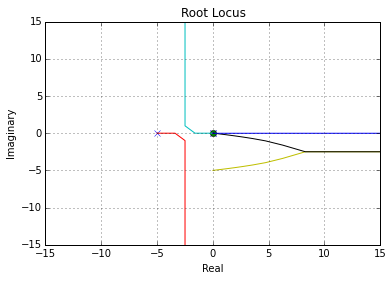

In [10]:
#add poles for a lead controller
zo = 0.01;
po = 5;
C=tf([1, zo],[1, po]);

r, k = rlocus(C*P_ball)
title("Root Locus")
plot(k,r)
grid()
ylim(-15, 15)
xlim(-15, 15)
show()


From here we can calulate a gain $K_c$ (MATLAB contains a function to find $K_c$,  `[k,poles]=rlocfind(C*P_ball)`, however `python-control` [doesn't dsupport it at the moment](http://python-control.sourceforge.net/manual/matlab_strings.html#matlab.initial)).   
The equation is 
$K_c = \frac{Product of Pole Distances}{Product of Zero Distances}$.  

If it's too difficult to calulate (some trigonometry is required), you may use trial and error, starting with $K_c=1$, and add it as a feedback to the system as shown here:

<img src=http://ctms.engin.umich.edu/CTMS/Content/BallBeam/Control/RootLocus/figures/feedback_ball.png>

In [11]:
k = 35;
sys_cl=feedback(k*C*P_ball);
sys_cl


       30.66 s + 0.3066
------------------------------
s^3 + 5 s^2 + 30.66 s + 0.3066

Now plot the response in a closed-looop with the step function. 

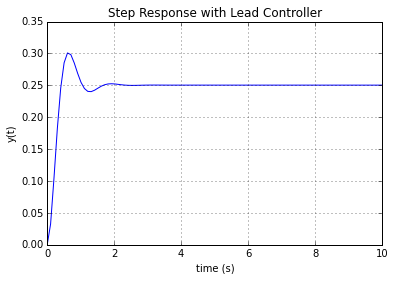

In [12]:
t, y = matlab.step(0.25*sys_cl,T=linspace(0,10,100))
plot(y, t)
title("Step Response with Lead Controller")
grid()
xlabel("time (s)")
ylabel("y(t)")

The system stabilizes at 2 second with a maximum 20% overshoot at the first second. However, it required a large $K_c$ and in a real life scenario, it may be too much energy needed, along with the possibility that if $K_c$ is too big in some models it may even destabilize otherwise stable models, with too much overshoot. 

##Frequency Domain Methods for Controller Design
###Open  Loop Bode Plot
The main idea of frequency based design is to use the [Bode plot](http://en.wikipedia.org/wiki/Bode_plot) of the open-loop transfer function to estimate the closed-loop response. Adding a controller to the system changes the open-loop Bode plot, therefore changing the closed-loop response. Let's first draw the bode plot for the original open-loop transfer function.

(array([  8.75892857e+01,   7.25802286e+01,   6.01430819e+01,
          4.98371301e+01,   4.12971777e+01,   3.42206078e+01,
          2.83566594e+01,   2.34975408e+01,   1.94710674e+01,
          1.61345593e+01,   1.33697859e+01,   1.10787765e+01,
          9.18034808e+00,   7.60722909e+00,   6.30367540e+00,
          5.22349507e+00,   4.32841144e+00,   3.58670685e+00,
          2.97209871e+00,   2.46280812e+00,   2.04078815e+00,
          1.69108435e+00,   1.40130482e+00,   1.16118112e+00,
          9.62204340e-01,   7.97323672e-01,   6.60696498e-01,
          5.47481378e-01,   4.53666488e-01,   3.75927456e-01,
          3.11509570e-01,   2.58130154e-01,   2.13897686e-01,
          1.77244772e-01,   1.46872599e-01,   1.21704918e-01,
          1.00849901e-01,   8.35685413e-02,   6.92484678e-02,
          5.73822423e-02,   4.75493804e-02,   3.94014504e-02,
          3.26497271e-02,   2.70549604e-02,   2.24188974e-02,
          1.85772573e-02,   1.53939100e-02,   1.27560523e-02,
        

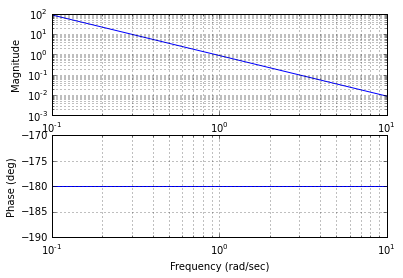

In [13]:
bode(P_ball)

From this plot we see that the phase margin is zero. Since the phase margin is defined as the change in open-loop phase shift necessary to make a closed-loop system unstable this means that our zero phase margin indicates our system is unstable. We want to increase the phase margin and we can use a lead compensator controller to do this.

###Phase Lead Controller
A first order phase-lead compensator has the form given below:

$$
C(s) = K \left( \frac{1+Ts}{1+aTs} \right)
$$

The phase-lead compensator will add positive phase to our system over the frequency range $1/aT$ and $1/T$, which are called the corner frequencies. The maximum added phase for one lead compensator is 90 degrees. For our controller design we need a percent overshoot of less than 5 %, which corresponds to a $\zeta$ of 0.7. Generally $\zeta$ * 100 will give you the minimum phase margin needed to obtain your desired overshoot.

So the steps are:
1. Determine the positive phase needed: We need at least 70 degrees from our controller.

2. Determine the frequency where the phase should be added (center frequency): In our case this is difficult to determine because the phase vs. frequency graph in the bode plot is a flat line. However, we have a relation between bandwidth frequency ($\omega_{\mathrm{bw}}$ ) and settling time which tells us that $\omega_{\mathrm{bw}}$ is approximately 1.92 rad/s. Therefore we want a center frequency just before this. For now we will choose 1.  
3. Determine the constant $a$ from the equation below: this determines the required space between the zero and the pole for the maximum phase added.  
$$
a =\frac{1-\sin\phi}{1+\sin\phi}
$$
where $\phi$ refers to the desired phase margin. For 70 degrees, $a = 0.0311$.  
4. Determine "T" and "aT" from the following equations:

$$
T = \frac{1}{w \sqrt{a}}
$$

$$
aT = \frac{\sqrt{a}}{w}
$$
For 70 degrees and center frequency $(w) = 1$, $aT = 0.176$ and $T = 5.67$  
Now, we can add our lead controller to the system and view the bode plot. 

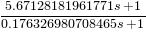

In [14]:
phi=70*pi/180;
a=(1-sin(phi))/(1+sin(phi));
w=1;
T=1/(w*sqrt(a));
K = 1;
C = K*(1+T*s)/(1+a*T*s);
C.simplify()


In [15]:
num = Poly(C.as_numer_denom()[0],s).all_coeffs()
den = Poly(C.as_numer_denom()[1],s).all_coeffs()
C =  tf(map(float,num),map(float,den))
C


 5.671 s + 1
------------
0.1763 s + 1

(array([  8.77298949e+03,   6.02836395e+03,   4.14376603e+03,
          2.84970330e+03,   1.96112830e+03,   1.35097727e+03,
          9.32000411e+02,   6.44285530e+02,   4.46690926e+02,
          3.10962638e+02,   2.17694949e+02,   1.53556788e+02,
          1.09387755e+02,   7.88918834e+01,   5.77424293e+01,
          4.29691077e+01,   3.25386065e+01,   2.50662333e+01,
          1.96157990e+01,   1.55591246e+01,   1.24768855e+01,
          1.00891496e+01,   8.20765926e+00,   6.70387796e+00,
          5.48811611e+00,   4.49615357e+00,   3.68076701e+00,
          3.00638855e+00,   2.44573762e+00,   1.97769009e+00,
          1.58591267e+00,   1.25793565e+00,   9.84408487e-01,
          7.58342642e-01,   5.74259372e-01,   4.27335897e-01,
          3.12775051e-01,   2.25577468e-01,   1.60692426e-01,
          1.13348577e-01,   7.93516964e-02,   5.52404613e-02,
          3.82988779e-02,   2.64757532e-02,   1.82648616e-02,
          1.25822532e-02,   8.65894102e-03,   5.95482772e-03,
        

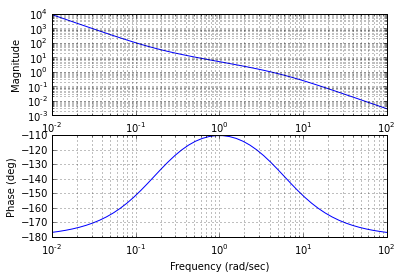

In [16]:
bode(C*P_ball)

You can see that our phase margin is now 70 degrees. Let's check the closed-loop response to a step input of 0.25m:

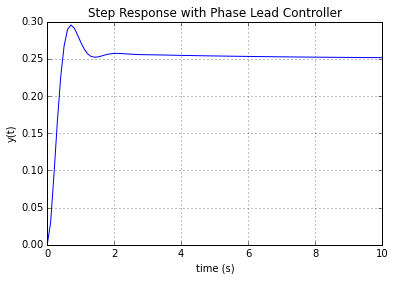

In [17]:
sys_cl = feedback(C*P_ball,1);
t, y = matlab.step(0.25*sys_cl,T=linspace(0,10,100))
plot(y, t)
title("Step Response with Phase Lead Controller")
grid()
xlabel("time (s)")
ylabel("y(t)")

This could be improved, by decreasing the gain to reduce overshoot. This reduces the crossover frequency and slows down the response time.

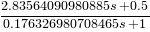

In [18]:
K = 0.5;
C = K*(1+T*s)/(1+a*T*s);
C.simplify()

In [19]:
num = Poly(C.as_numer_denom()[0],s).all_coeffs()
den = Poly(C.as_numer_denom()[1],s).all_coeffs()
C =  tf(map(float,num),map(float,den))
C


2.836 s + 0.5
-------------
 0.1763 s + 1

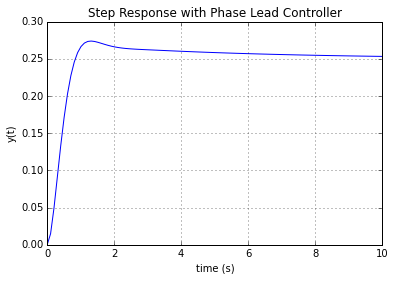

In [20]:
sys_cl = feedback(C*P_ball,1);
t, y = matlab.step(0.25*sys_cl,T=linspace(0,10,100))
plot(y, t)
title("Step Response with Phase Lead Controller")
grid()
xlabel("time (s)")
ylabel("y(t)")

##State Space

A control model may be represented also in a [state-space model](http://en.wikipedia.org/wiki/State_space), which use state variables to describe a system by a set of first-order differential or difference equations, rather than by one or more $nth$-order differential or difference equations. 
In our ball and beam model, this can be done by selecting the ball's position ($r$) and velocity ($\dot{r}$) as the state variable and the gear angle ($\theta$) as the input. The state-space representation is shown below:

$$
\begin{bmatrix} 
\dot{r} \\
\ddot{r} \\
\dot{\alpha}\\
\ddot{\alpha}
\end{bmatrix}
=
\begin{bmatrix}
    0 & 1 & 0 & 0\\
    0 & 0 & \frac{-mg}{(\frac{J}{R^2}+m)} & 0 \\
    0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0
\end{bmatrix}
\begin{bmatrix} 
r \\
\dot{r} \\
\alpha\\
\dot{\alpha}
\end{bmatrix}
+
\begin{bmatrix} 
0 \\
0 \\
0\\
1
\end{bmatrix}
u
$$

$$
y = 
\begin{bmatrix} 
1 & 0 & 0 & 0
\end{bmatrix}
\begin{bmatrix} 
r \\
\dot{r} \\
\alpha\\
\dot{\alpha}
\end{bmatrix}
$$

###Full state-feedback controller
We will design a controller for this physical system that utilizes [full state-feedback control](http://en.wikipedia.org/wiki/Full_state_feedback). 
 A schematic of this type of system is shown below:
 <img src=http://ctms.engin.umich.edu/CTMS/Content/BallBeam/Control/StateSpace/figures/statefeedback_ball.png>  
 The characteristic polynomial for this closed-loop system is the determinant of $(sI-(A-BK))$, where $s$ is the Laplace variable. For our system the $A$ and $B*K$ matrices are both 4x4. Hence, there should be four poles for our system. In designing our full-state feedback controller we can move these poles anywhere we want.

In [1]:
import control
from numpy import *             # Grab all of the NumPy functions
from control import matlab
from control.matlab import *    # MATLAB-like functions
from matplotlib.pyplot import * # Grab MATLAB plotting functions
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
m = 0.04;
R = 0.0127;
g = -9.81;
J = 0.00000258064;

H = -m*g/(J/(R**2)+m);

A = matrix(
    [[0, 1, 0, 0],
     [0, 0, H, 0],
     [0, 0, 0, 1],
     [0, 0, 0, 0]]);
B = matrix([[0],
            [0],
            [0],
            [1]]);
C = matrix([1, 0, 0, 0]);
D = matrix([0]);

ball_ss = ss(A,B,C,D);

ball_ss

A = [[ 0.          1.          0.          0.        ]
 [ 0.          0.          7.00714286  0.        ]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.          0.        ]]

B = [[0]
 [0]
 [0]
 [1]]

C = [[1 0 0 0]]

D = [[0]]

For our design we desire an overshoot of less than 5% which corresponds to a $\zeta = 0.7$. On a root locus, this criterion is represented as a 45 degree line emanating from the origin and extending out into the left-half plane. We want to place our desired poles on or beneath this line. Our next criterion is a settling time less than 3 seconds, which corresponds to a $\sigma = 4.6/Ts = 4.6/3 = 1.53$, represented by a vertical line at -1.53 on the root locus. Anything beyond this line in the left-half plane is a suitable place for our poles. Therefore we will place our poles at $-2+2i$ and $-2-2i$. We will place the other poles far to the left for now, so that they will not affect the response too much. To start with place them at -20 and -80. Now that we have our poles we can use the  `place` command to find the controller (K matrix). 

In [22]:
p1 = complex(-2,2);
p2 = complex(-2,-2);
p3 = -20;
p4 = -80;

K = place(A,B,[p1,p2,p3,p4])

/home/notebook/ka_env/lib/python2.7/site-packages/slycot/synthesis.py:170: UserWarning: 2 violations of the numerical stability condition occured during the assignment of eigenvalues
  warnings.warn('%i violations of the numerical stability condition occured during the assignment of eigenvalues' % warn)


In [23]:
K

array([[ 1826.70744139,  1027.52293578,  2008.        ,   104.        ]])

After adding the K matrix, the state space equations now become:

$$
\dot{{\bf x}} = (A-BK){\bf x} + Bu
$$

$$
y = C{\bf x}
$$

We can now simulate the closed-loop response to a 0.25m step input by using the `lsim` command. 

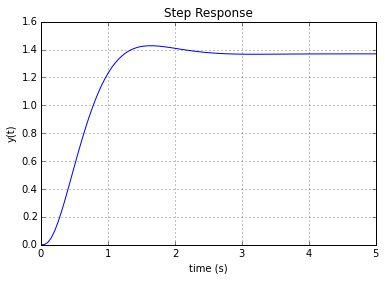

In [25]:
t = linspace(0,5,100);
u = 0.25*ones(size(t));
sys_cl = ss(A-(B*K),B,C,D);
[y,t,x] = lsim(1e4*sys_cl,u,t);
plot(t,y)
title("Step Response")
grid()
xlabel("time (s)")
ylabel("y(t)")

##References

1. [Control Tutorials for MATLAB, University of Michigan](http://ctms.engin.umich.edu/CTMS/index.php?aux=Home)
2. [Wikipedia](https://www.en.wikipedia.org) for background theory